# Variational Autoregressive Network on Ising Model

Here, we attempt to sample and output log-probabilities approximately using a variational autoregressive network that trains to minimize free energy

If opening directly on Colab (or downloaded this notebook alone locally), run the following cell to download the dependencies of this noteook:

In [ ]:
!curl -o ising.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/ising.py
!curl -o train.py https://raw.githubusercontent.com/dinesh110598/ising-autoregressive/main/train.py

Here, we import tensorflow (2.x) and other dependent modules:

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
import train #User defined module to run training loop
import ising #User defined module to define the models

We're going to use the PixelCNN architecture which uses a masked convolutional neural network to return some probabilities, given an input lattice of Ising spins. Let's initialize the network with depth 2 first:

In [5]:
model = ising.PixelCNN(L=24, net_depth=3, net_width=32, kernel_size=3)#See ising.py for more details
ising.J = -1. #Fixes the coupling constant in Ising model

Let's check out the model design here:

In [6]:
model.net.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d_2 (MaskedConv2 (None, 24, 24, 32)        320       
_________________________________________________________________
res_block_1 (ResBlock)       (None, 24, 24, 32)        10304     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 1)         33        
Total params: 10,657
Trainable params: 10,657
Non-trainable params: 0
_________________________________________________________________


This is an unsupervised learning model since the network generates its own training data. In particular, we're attempting reinforcement learning to optimize the (expectation value of) free energy of the generated lattices. Let's train a 20x20 lattice and output its history (how metrics like free energy and energy evolve with successive training steps):

In [4]:
history = train.train_loop(iter=20, batch_size=50, 
            beta=2, net=model, anneal=True)
#Set anneal=False if you are running this cell second 
#time to train this model further

100%|██████████| 20/20 [03:46<00:00, 11.30s/it]


The output object "history" is a python dictionary which records the values of various metrics like free energy, energy and time taken per training step. This helps us visualize how the training performance so that we can tweak various parameters to improve it. Here, we plot mean energy against the training step:

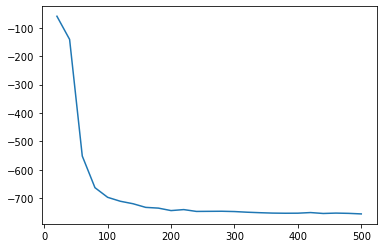

In [5]:
x = history['step']
y = history['Energy mean']
plt.plot(x, y)

Since we set beta=2 (low temperature) we know a good model would sample lattices with (nearly) ground state energies

The ground state energy of ferromagnetic Ising lattice with L=20:

In [6]:
lattice = tf.ones([1,20,20,1], tf.float32)
energy = ising.energy(lattice)
tf.print(energy)
#Here, we print the mean energy sampled between the 
#steps 1000 and 2000 
print(np.mean(history['Energy mean'][-10:]))

[-760]
-751.91595


Since this model seems to work very well (atleast for the simplest Ising lattices), let's save the weights here:

In [12]:
model.save_weights("saved_chkpt")

Let's calculate and plot the exact theoretical free energy of the infinite square ferromagnetic Ising model($K=\beta$). We'll use the SciPy method "quad" to find this integral:
$$ -\beta F = \frac{log(2)}{2} + \frac{1}{2 \pi} \int_0^\pi log\left[ cosh^2(2K) + \frac{1}{k}\sqrt{1 + k^2 - 2k.cos(2\theta)} \right] d\theta$$
where $$ k = \frac{1}{sinh^2(2K)}$$

In [14]:
from scipy import integrate
import math

In [21]:
#The function to evaluate integral of
def func(theta, beta):
    t1 = math.cosh(2*beta)**2
    k = 1./(math.sinh(2*beta)**2)
    t2 = (1./k)*math.sqrt(1 + k**2 - 2*k*math.cos(2*theta))
    return math.log(t1 + t2)

We use this function to evaluate the integral over a vector of values for beta:

In [22]:
def integrator(beta):
    result = np.empty(beta.shape, float)
    for i in range(beta.shape[0]):
        val = beta[i]
        integrand = lambda theta: func(theta, val)
        result[i] = integrate.quad(integrand, 0 , math.pi)[0]
    return result

In [26]:
beta = np.arange(0.4, 1, 0.05)
integral = integrator(beta)
F = -np.reciprocal(beta)*(math.log(2)/2 + integral*(1./(2*math.pi)))

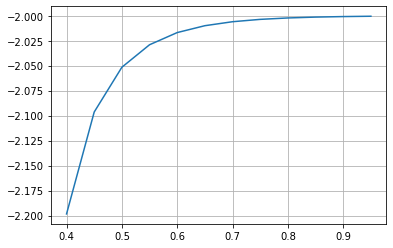

In [27]:
plt.plot(beta, F)
plt.grid()
plt.show()

Now, let's load one of the pre-trained weights for the model for beta=1

In [11]:
model.load_weights("Saved Weights/Beta_0.3")

We'll sample a batch of 50 lattice and find the average free energy:

In [12]:
sample = model.sample(50)
energy = ising.energy(sample)
beta = 1.
log_prob = model.log_prob(sample)
free_energy = (log_prob + beta*energy)/(model.L**2)

In [13]:
np.mean(free_energy)

-1.251625